In [85]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow.keras import datasets, layers, utils, Sequential, Model
import matplotlib.pyplot as plt

# Utils

In [86]:
(train_x, train_y), (test_x, test_y) = datasets.mnist.load_data()
train_x = train_x.reshape([train_x.shape[0], -1]) / 255.
test_x = test_x.reshape([test_x.shape[0], -1]) / 255.

train_y = utils.to_categorical(train_y, 10)
test_y = utils.to_categorical(test_y, 10)

In [87]:
print(train_x.shape, test_x.shape)

(60000, 784) (10000, 784)


In [88]:
def plot_wb(model):
    pos_last_layer = len(model.layers) - 1

    for i, l in enumerate(model.layers):

        # Take all dense layer except last one,
        if i != pos_last_layer and  i % 2 == 0:

            # Plot.
            fig = plt.figure(figsize=(15,5))

            fig.add_subplot(1,2,1)
            plt.title("weights " + l.name)
            plt.hist(l.get_weights()[0].flatten(), bins=100);

            fig.add_subplot(1,2,2)
            plt.title("biases " + l.name)
            plt.hist(l.get_weights()[1].flatten(), bins=100);

def wb_non_zero_percentage(model):
    pos_last_layer = len(model.layers) - 1

    for i, l in enumerate(model.layers):

        # Take all dense layer except last one,
        if i != pos_last_layer and  i % 2 == 0:
            w, b = model.layers[0].get_weights()

            non_zero_w = tf.math.count_nonzero(w)
            total_w = tf.reshape(w, [-1]).shape[0]
            res_w = (non_zero_w / total_w).numpy() * 100

            non_zero_b = tf.math.count_nonzero(w)
            total_b = tf.reshape(w, [-1]).shape[0]
            res_b = (non_zero_b / total_b).numpy() * 100

            print("Percentage of non-zero value " + l.name + ": w = {} | b = {}".format(res_w, res_b))

# Model creation

In [89]:
# class DSD_layer(Model):
#     def __init__(self, sparse_training = False, sparsity=0.5):
#         super(DSD_layer, self).__init__()
        
#         self.sparse_training = sparse_training
#         self.sparsity = sparsity
    
#     def call(self, x):
#         if self.sparse_training:
#             print("sparse_training")
#             return tf.custom_gradient(lambda x: self.func(x))(x)
        
#         print("Regular")
#         return x
    
#     def func(self, x):
    
#         qk = tfp.stats.percentile(tf.math.abs(x), q = self.sparsity * 100)
#         f = tf.where(tf.math.abs(x) <= qk, 0., x)

#         mask = tf.where(tf.math.abs(x) <= qk, 0., 1.)
        
#         def grad(dy):
            
#             #mask = tf.where(tf.math.abs(x) <= qk, 0., 1.)
#             return dy * mask

#         return f, grad

class DSD_layer(Model):
    def __init__(self, sparse_training = False, sparsity=0.5):
        super(DSD_layer, self).__init__()
        
        self.sparse_training = sparse_training
        self.sparsity = sparsity
    
    def call(self, x):
        if self.sparse_training:
            print("sparse_training")
        
            qk = tfp.stats.percentile(tf.math.abs(x), q = self.sparsity * 100)
            mask = tf.where(tf.math.abs(x) <= qk, 0., 1.)
            return x * mask
        
        print("Regular")
        return x

In [90]:
class NN(Model):
    def __init__(self, inputs_shape= 28 * 28):
        super(NN, self).__init__()
        
        self.inputs_shape = inputs_shape
        
        self.fc1 = layers.Dense(512, activation="relu", kernel_initializer='glorot_uniform')
        self.dsd1 = DSD_layer()
        self.fc2 = layers.Dense(256, activation="relu", kernel_initializer='glorot_uniform')
        self.dsd2 = DSD_layer()
        self.fc3 = layers.Dense(128, activation="relu", kernel_initializer='glorot_uniform')
        self.dsd3 = DSD_layer()
        self.fc4 = layers.Dense(10, activation="softmax", kernel_initializer='glorot_uniform')
        
    def call(self, x):
        x = self.fc1(x)
        x = self.dsd1(x)
        x = self.fc2(x)
        x = self.dsd2(x)
        x = self.fc3(x)
        x = self.dsd3(x)
        x = self.fc4(x)
        return x

    def model(self):
        x = layers.Input(shape=self.inputs_shape)
        return Model(inputs=[x], outputs = self.call(x))

In [91]:
model = NN()
model.model().summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Regular
Regular
Regular
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               401920    
_________________________________________________________________
dsd_layer_18 (DSD_layer)     (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dsd_layer_19 (DSD_layer)     (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dsd_layer_20 (DSD_layer)     (None,

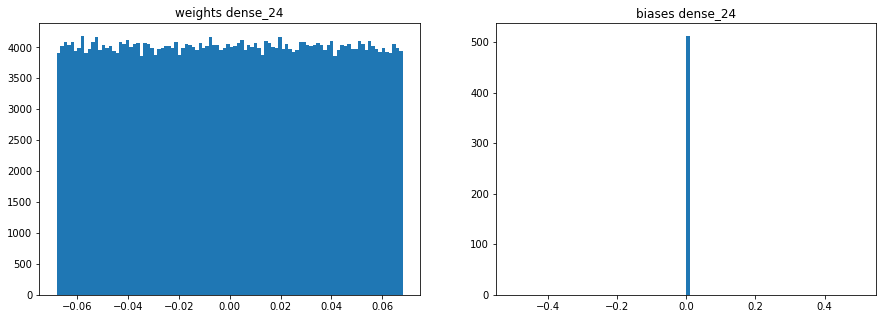

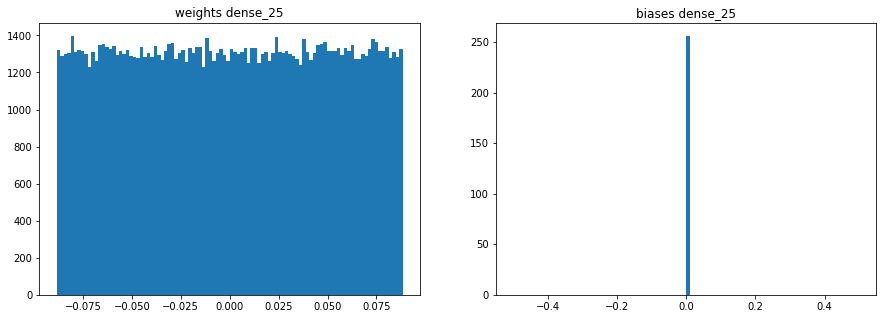

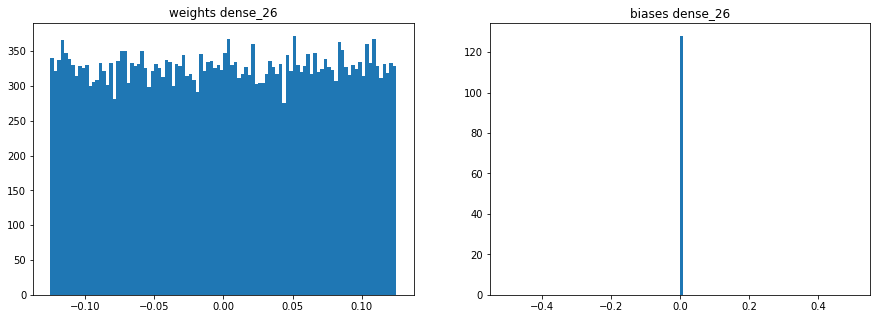

In [92]:
plot_wb(model)

# I/ Training

In [93]:
model.fit(train_x, train_y, epochs=1, workers=1)

Regular
Regular
Regular
Regular
Regular
Regular
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3240 - accuracy: 0.9011


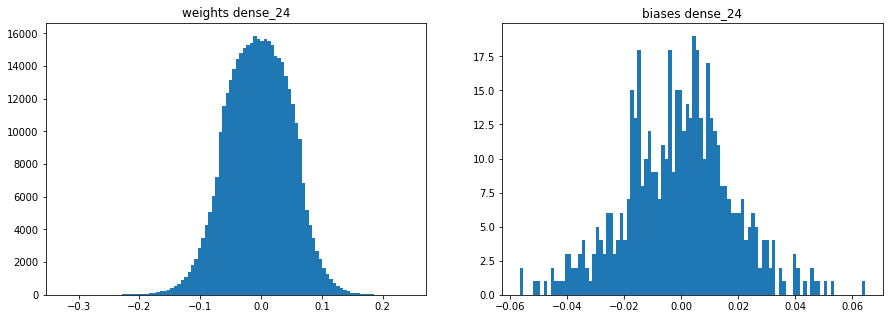

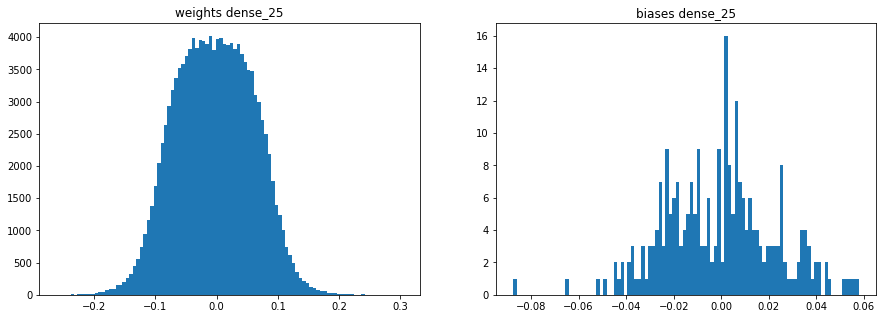

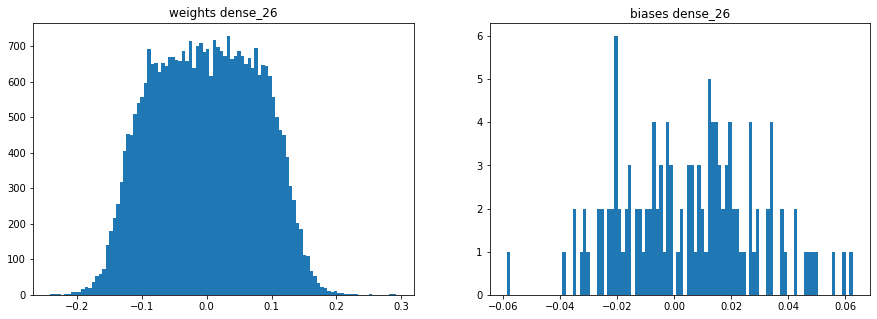

In [94]:
plot_wb(model)

# II/ Prune the network

In [95]:
# sparsity = 0.25
# w = model.layers[0].get_weights()[0]

# qk = tfp.stats.percentile(tf.math.abs(w), q = sparsity * 100)
# pruned = tf.where(tf.math.abs(w) <= qk, 0., w)

# non_zero = tf.math.count_nonzero(pruned)
# total = tf.reshape(w, [-1]).shape[0]
# print("Percentage of non zero value:", (non_zero / total).numpy())

In [96]:
# plt.figure()
# plt.hist(pruned.numpy().flatten(), bins=100, range=(-0.055, 0.055));

In [97]:
def pruning(wb, sparsity = 0.50):
    """
        Returns mask for weights and biases.
    """

    w = tf.convert_to_tensor(wb[0], dtype=tf.float32)
    b = tf.convert_to_tensor(wb[1], dtype=tf.float32)
    
    # Weight
    qk = tfp.stats.percentile(tf.math.abs(w), q = sparsity * 100)
    mask_w = tf.where(tf.math.abs(w) <= qk, 0., 1.)
    
    # Bias
    qk = tfp.stats.percentile(tf.math.abs(b), q = sparsity * 100)
    mask_b = tf.where(tf.math.abs(b) <= qk, 0., 1.)
    
    #print("Mask shape:", mask_w.shape, mask_b.shape)
    
    return mask_w, mask_b

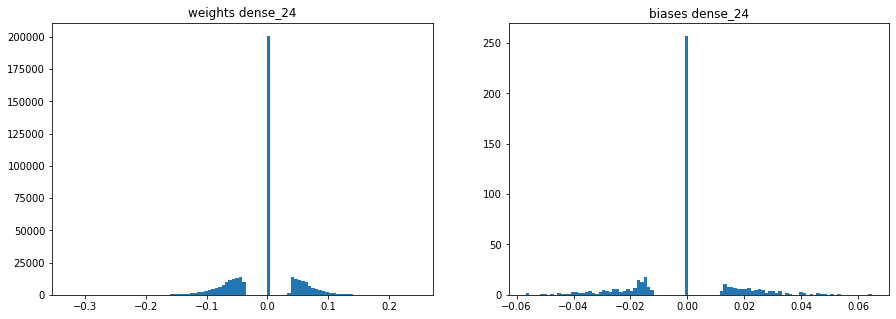

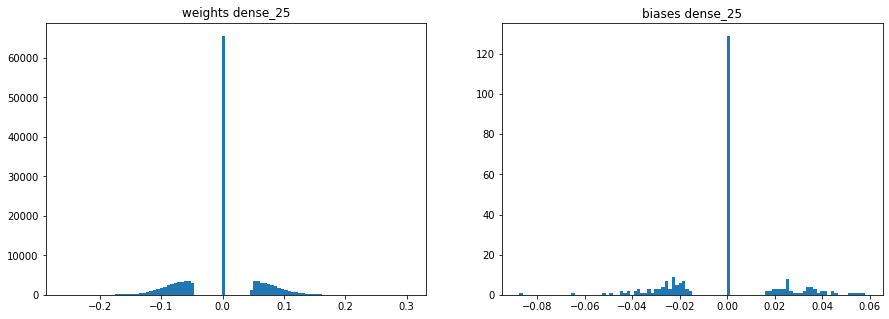

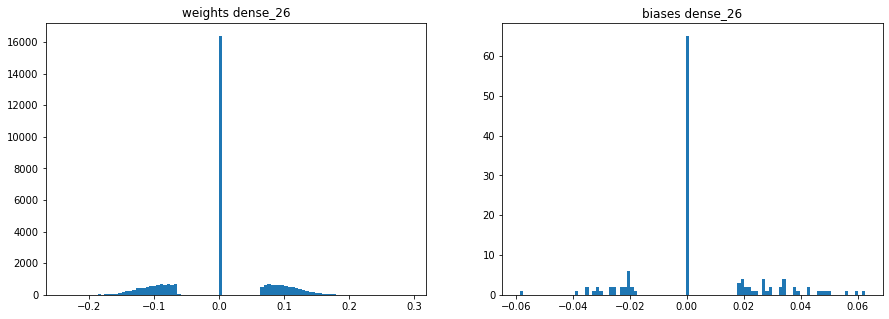

In [98]:
pos_last_layer = len(model.layers) - 1

for i, l in enumerate(model.layers):
    
    # Take all dense layer except last one,
    if i != pos_last_layer and  i % 2 == 0:
        
        wb = l.get_weights()
        
        mask_w, mask_b = pruning(wb)        
        wb[0] = wb[0] * mask_w
        wb[1] = wb[1] * mask_b
        
        l.set_weights(wb)
        
        # Plot.
        fig = plt.figure(figsize=(15,5))
        
        fig.add_subplot(1,2,1)
        plt.title("weights " + l.name)
        plt.hist(l.get_weights()[0].flatten(), bins=100);
        
        fig.add_subplot(1,2,2)
        plt.title("biases " + l.name)
        plt.hist(l.get_weights()[1].flatten(), bins=100);

In [99]:
wb_non_zero_percentage(model)

Percentage of non-zero value dense_24: w = 49.99975087691326 | b = 49.99975087691326
Percentage of non-zero value dense_25: w = 49.99975087691326 | b = 49.99975087691326
Percentage of non-zero value dense_26: w = 49.99975087691326 | b = 49.99975087691326


# III/ Train on Sparse

In [100]:
model.layers[1].sparse_training = True
model.layers[3].sparse_training = True
model.layers[5].sparse_training = True

In [101]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_x, train_y, epochs=1)

sparse_training
sparse_training
sparse_training
sparse_training
sparse_training
sparse_training
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0968 - accuracy: 0.9703


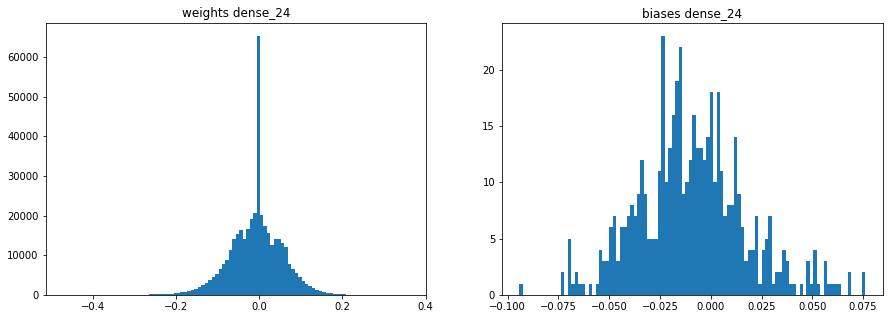

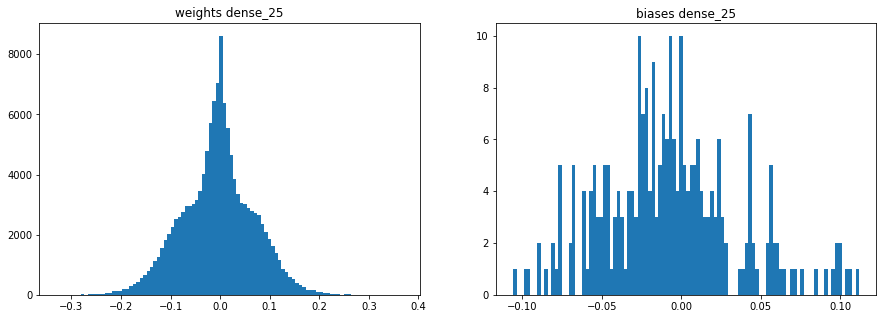

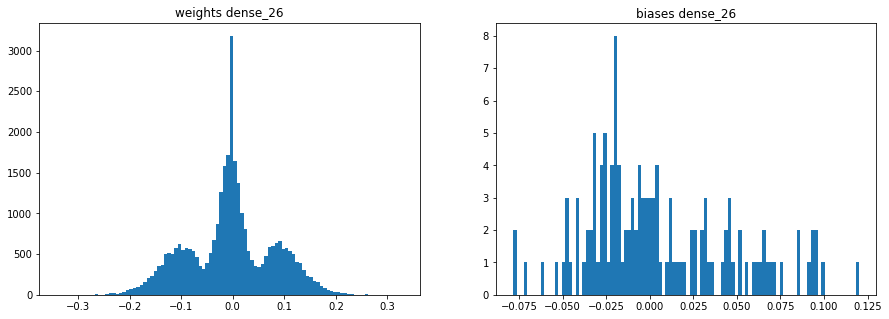

In [102]:
plot_wb(model)

In [103]:
wb_non_zero_percentage(model)

Percentage of non-zero value dense_24: w = 90.39306640625 | b = 90.39306640625
Percentage of non-zero value dense_25: w = 90.39306640625 | b = 90.39306640625
Percentage of non-zero value dense_26: w = 90.39306640625 | b = 90.39306640625
